In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as Math
import tensorflow
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, TimeDistributed, LSTM, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import random
import os

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
BASIN = 'NA' # Change to BASIN you want to work for

path1 = os.getcwd()+'/'

#Limiting GPU RAM. Comment these lines if you are not working on a shared GPU.
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
sess = tensorflow.compat.v1.Session(config=config)

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
filePath = path1 + 'NAreanalysisData.csv'
data = pd.read_csv(filePath, index_col=0)

In [4]:
#Scaling the data
total_hurricane_count = len(pd.unique(data['SID']))
print("total hurricane count  ", total_hurricane_count)
gridSize = 41
total = gridSize*gridSize
scalers = {}
cols = []

for i in range(total):
  cols.append('r225_'+str(i))
for i in range(total):
  cols.append('r500_'+str(i))
for i in range(total):
  cols.append('r700_'+str(i))
for i in range(total):
  cols.append('t225_'+str(i))
for i in range(total):
  cols.append('t500_'+str(i))
for i in range(total):
  cols.append('t700_'+str(i))


for i in range(total):
  cols.append('u225_'+str(i))
for i in range(total):
  cols.append('u500_'+str(i))
for i in range(total):
  cols.append('u700_'+str(i))
for i in range(total):
  cols.append('v225_'+str(i))
for i in range(total):
  cols.append('v500_'+str(i))
for i in range(total):
  cols.append('v700_'+str(i))
for i in range(total):
  cols.append('z225_'+str(i))
for i in range(total):
  cols.append('z500_'+str(i))
for i in range(total):
  cols.append('z700_'+str(i))

for col in cols:
    scaler = MinMaxScaler((-1,1))
    scaler.fit(data[[col]])
    data[[col]] = scaler.transform(data[[col]])

cols.append('cateogry')


total hurricane count   1306


In [6]:
data_pad = []
for key in np.unique(data['SID']):
    data_pad += [data[ data.loc[:, 'SID'] == key].loc[:, cols].values]

In [7]:
# Extracting features indexes and adjusting them as per used features, to index in data_pad.

offset = 4  #As SID, ISO_TIME, LAt, LON not used.


r225fIndex = data.columns.get_loc('r225_0')-offset
r225lIndex = data.columns.get_loc('r225_1680')-offset 
t225fIndex = data.columns.get_loc('t225_0')-offset
t225lIndex = data.columns.get_loc('t225_1680')-offset 
u225fIndex = data.columns.get_loc('u225_0')-offset
u225lIndex = data.columns.get_loc('u225_1680')-offset 
v225fIndex = data.columns.get_loc('v225_0')-offset
v225lIndex = data.columns.get_loc('v225_1680')-offset 
z225fIndex = data.columns.get_loc('z225_0')-offset
z225lIndex = data.columns.get_loc('z225_1680')-offset


r500fIndex = data.columns.get_loc('r500_0')-offset
r500lIndex = data.columns.get_loc('r500_1680')-offset
t500fIndex = data.columns.get_loc('t500_0')-offset
t500lIndex = data.columns.get_loc('t500_1680')-offset
u500fIndex = data.columns.get_loc('u500_0')-offset
u500lIndex = data.columns.get_loc('u500_1680')-offset
v500fIndex = data.columns.get_loc('v500_0')-offset
v500lIndex = data.columns.get_loc('v500_1680')-offset
z500fIndex = data.columns.get_loc('z500_0')-offset
z500lIndex = data.columns.get_loc('z500_1680')-offset


r700fIndex = data.columns.get_loc('r700_0')-offset
r700lIndex = data.columns.get_loc('r700_1680')-offset
t700fIndex = data.columns.get_loc('t700_0')-offset
t700lIndex = data.columns.get_loc('t700_1680')-offset 
u700fIndex = data.columns.get_loc('u700_0')-offset
u700lIndex = data.columns.get_loc('u700_1680')-offset
v700fIndex = data.columns.get_loc('v700_0')-offset
v700lIndex = data.columns.get_loc('v700_1680')-offset 
z700fIndex = data.columns.get_loc('z700_0')-offset 
z700lIndex = data.columns.get_loc('z700_1680')-offset 

cateogryIndex = data.columns.get_loc('cateogry')-offset

gridSize = 41

#Training dataset prepearation.
def load_dataCNN(data_pad, trainPoints):
    X = []
    y = []
    leads = []
    #count  = 0
    for cdata in data_pad:
      #count = count + 1
      yy = cdata[0][cateogryIndex]
      length = len(cdata)
      diff = length - trainPoints +1
      for i in range(diff):
          data2 = []
          cc1 = cdata[i : i + trainPoints]
          leads.append(diff-i)
          for j in range(trainPoints):
              data1 = []
              value = cc1[j]
                
              r225 = np.reshape(value[r225fIndex: r225lIndex+1], (gridSize,gridSize))
              r500 = np.reshape(value[r500fIndex: r500lIndex+1], (gridSize,gridSize))
              r700 = np.reshape(value[r700fIndex: r700lIndex+1], (gridSize,gridSize))

              t225 = np.reshape(value[t225fIndex: t225lIndex+1], (gridSize,gridSize))
              t500 = np.reshape(value[t500fIndex: t500lIndex+1], (gridSize,gridSize))
              t700 = np.reshape(value[t700fIndex: t700lIndex+1], (gridSize,gridSize))
            
              u225 = np.reshape(value[u225fIndex: u225lIndex+1], (gridSize,gridSize))
              u500 = np.reshape(value[u500fIndex: u500lIndex+1], (gridSize,gridSize))
              u700 = np.reshape(value[u700fIndex: u700lIndex+1], (gridSize,gridSize))

              v225 = np.reshape(value[v225fIndex: v225lIndex+1], (gridSize,gridSize))
              v500 = np.reshape(value[v500fIndex: v500lIndex+1], (gridSize,gridSize))
              v700 = np.reshape(value[v700fIndex: v700lIndex+1], (gridSize,gridSize))

              z225 = np.reshape(value[z225fIndex: z225lIndex+1], (gridSize,gridSize))
              z500 = np.reshape(value[z500fIndex: z500lIndex+1], (gridSize,gridSize))
              z700 = np.reshape(value[z700fIndex: z700lIndex+1], (gridSize,gridSize))

                
              data1.append(r225)
              data1.append(r500)
              data1.append(r700)
              data1.append(t225)
              data1.append(t500)
              data1.append(t700)
              data1.append(u225)
              data1.append(u500)
              data1.append(u700)
              data1.append(v225)
              data1.append(v500)
              data1.append(v700)
              data1.append(z225)
              data1.append(z500)
              data1.append(z700)
              data2.append(data1)
          X.append(data2)
          y.append(yy)

    X = np.array(X)
    y = np.array(y)
    leads = np.array(leads)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], X.shape[3],X.shape[4])) 
    return [x_train, y, leads]

def build_model(inputShape):
    noOfPredFeatures=1
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation = 'relu',data_format = 'channels_first'), input_shape=inputShape[1:]))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=48, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding = 'same', activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(Dense(noOfPredFeatures, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def leadTimeWiseScores(leadsTime, actuals, predicts):
    leadsCount = leadsTime[0].max()
    length1 = len(leadsTime)
    accuracy = []
    fprs = []
    recalls = []
    precis = []
    f1scores = []
    conMats = []
    for i in range(length1):
        conMat = [[[0,0],[0,0]]]*leadsCount
        conMat = np.array(conMat)
        leads  = leadsTime[i]
        actual = actuals[i]
        predict = predicts[i]
        
        for j in range(len(leads)):
            lead = leads[j]
            pred = predict[j]
            act = actual[j]
            conMat[lead-1][act][pred] = conMat[lead-1][act][pred] +1
        conMats.append(conMat)
    
    for i in range(leadsCount):
        accuracy = []
        fprs = []
        recalls = []
        precis = []
        f1scores = []
        for j in range(length1):
            confs = conMats[j]
            cfm = confs[i]
            TN = cfm[0,0]
            FP = cfm[0,1]
            FN = cfm[1,0]
            TP = cfm[1,1]
            acc = (TP+TN)/(TP+TN+FP+FN)
            fpr = FP/(FP+TN)
            recal = TP/(TP+FN)
            prec = TP/(TP+FP)
            f1 = (2*prec*recal)/(prec+recal)
            accuracy.append(acc)
            fprs.append(fpr)
            recalls.append(recal)
            precis.append(prec)
            f1scores.append(f1)
        print("LEAD TIME ======= ", i*6 + 24 )
        print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
        print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
        print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
        print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
        print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())           
        

In [10]:
from sklearn.metrics import confusion_matrix

noOfTrain = 3 # T = 3 (12 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=64, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   3  or  12  hours
Train on 7313 samples, validate on 1829 samples
Epoch 1/30
7313/7313 [==============================] - 14s 2ms/sample - loss: 0.5815 - acc: 0.7081 - val_loss: 0.4949 - val_acc: 0.7715
Epoch 2/30
7313/7313 [==============================] - 8s 1ms/sample - loss: 0.4619 - acc: 0.7859 - val_loss: 0.4623 - val_acc: 0.7764
Epoch 3/30
7313/7313 [==============================] - 8s 1ms/sample - loss: 0.4396 - acc: 0.7958 - val_loss: 0.4473 - val_acc: 0.7846
Epoch 4/30
7313/7313 [==============================] - 7s 955us/sample - loss: 0.4201 - acc: 0.8081 - val_loss: 0.4243 - val_acc: 0.7933
Epoch 5/30
7313/7313 [==============================] - 9s 1ms/sample - loss: 0.3866 - acc: 0.8251 - val_loss: 0.4141 - val_acc: 0.7977
Epoch 6/30
7313/7313 [==============================] - 7s 946us/sample - loss: 0.3595 - acc: 0.8433 - val_loss: 0.3820 - val_acc: 0.8261
Epoch 7/30
7313/7313 [==============================] - 8s 1ms/sample - loss: 0.3361 - ac

In [11]:
from sklearn.metrics import confusion_matrix

noOfTrain = 5 # T = 5 (24 hours)
print("No of data points used  ",noOfTrain," or ", (noOfTrain-1)*6," hours")
print("===========================================================")
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)
yy = yy.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fprs = []
tprs = []
aucs = []
recalls = []
precis = []
f1scores = []

leadTimes = []
actuals = []
predicts = []
for train_index, test_index in kf.split(cnnData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    leadsTest = leads[test_index]

    model = build_model(cnnData.shape)
    model.fit(Xc_train, yc_train, batch_size=64, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)
    predictions = model.evaluate(Xc_test, yc_test)
    accuracy.append(predictions[1])
    ypred = model.predict(Xc_test)
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yc_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    
    leadTimes.append(leadsTest)
    actuals.append(yc_test)
    predicts.append(ypred)
    cfm = confusion_matrix(yc_test, ypred)

    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    fpr = FP/(FP+TN)
    tpr = TP/(TP+FN)
    recal = TP/(TP+FN)
    prec = TP/(TP+FP)
    f1 = (2*prec*recal)/(prec+recal)
    
    precis.append(prec)
    fprs.append(fpr)
    recalls.append(recal)
    f1scores.append(f1)
    print("accuracy  ", accuracy)
    print("precis  ", precis)
    print("fprs  ", fprs)
    print("recalls  ", recalls)
    print("f1scores  ", f1scores)

print("5 Fold accuracy of model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold precis of  model ", np.array(precis).mean(), ' std  ', np.array(precis).std())
print("5 Fold recalls of  model ", np.array(recalls).mean(), ' std  ', np.array(recalls).std())
print("5 Fold f1scores of  model ", np.array(f1scores).mean(), ' std  ', np.array(f1scores).std())
print("5 Fold fprs of  model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())   
print("5 Fold AUC of  model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())

leadTimeWiseScores(leadTimes, actuals, predicts)


No of data points used   5  or  24  hours
Train on 5224 samples, validate on 1306 samples
Epoch 1/30
5224/5224 [==============================] - 11s 2ms/sample - loss: 0.5338 - acc: 0.7280 - val_loss: 0.4711 - val_acc: 0.7764
Epoch 2/30
5224/5224 [==============================] - 8s 1ms/sample - loss: 0.4579 - acc: 0.7875 - val_loss: 0.4421 - val_acc: 0.7864
Epoch 3/30
5224/5224 [==============================] - 8s 2ms/sample - loss: 0.4314 - acc: 0.8044 - val_loss: 0.4242 - val_acc: 0.8002
Epoch 4/30
5224/5224 [==============================] - 7s 1ms/sample - loss: 0.3861 - acc: 0.8319 - val_loss: 0.4237 - val_acc: 0.8139
Epoch 5/30
5224/5224 [==============================] - 7s 1ms/sample - loss: 0.3751 - acc: 0.8344 - val_loss: 0.3790 - val_acc: 0.8300
Epoch 6/30
5224/5224 [==============================] - 7s 1ms/sample - loss: 0.3433 - acc: 0.8528 - val_loss: 0.3465 - val_acc: 0.8515
Epoch 7/30
5224/5224 [==============================] - 7s 1ms/sample - loss: 0.3161 - acc: 0

Train on 7313 samples, validate on 1829 samples
Epoch 1/30
7313/7313 [==============================] - 14s 2ms/sample - loss: 0.5220 - acc: 0.7581 - val_loss: 0.5155 - val_acc: 0.7698
Epoch 2/30
7313/7313 [==============================] - 13s 2ms/sample - loss: 0.4603 - acc: 0.7857 - val_loss: 0.4785 - val_acc: 0.7698
Epoch 3/30
7313/7313 [==============================] - 11s 1ms/sample - loss: 0.4448 - acc: 0.7916 - val_loss: 0.4669 - val_acc: 0.7846
Epoch 4/30
7313/7313 [==============================] - 11s 2ms/sample - loss: 0.4081 - acc: 0.8143 - val_loss: 0.4258 - val_acc: 0.7993
Epoch 5/30
7313/7313 [==============================] - 11s 2ms/sample - loss: 0.3860 - acc: 0.8267 - val_loss: 0.4106 - val_acc: 0.8086
Epoch 6/30
7313/7313 [==============================] - 11s 2ms/sample - loss: 0.3701 - acc: 0.8382 - val_loss: 0.3920 - val_acc: 0.8289
Epoch 7/30
7313/7313 [==============================] - 13s 2ms/sample - loss: 0.3364 - acc: 0.8561 - val_loss: 0.4112 - val_acc: 

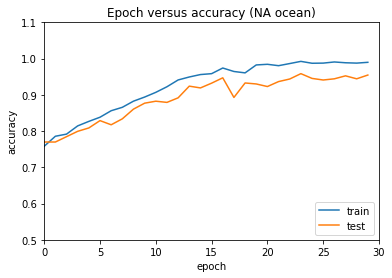

In [11]:
#Generating epoc s train versus test accuracy
noOfTrain = 3 # T = 3 (12 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoch versus accuracy (NA ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Train on 5224 samples, validate on 1306 samples
Epoch 1/30
5224/5224 [==============================] - 17s 3ms/sample - loss: 0.5267 - acc: 0.7531 - val_loss: 0.4944 - val_acc: 0.7795
Epoch 2/30
5224/5224 [==============================] - 11s 2ms/sample - loss: 0.4600 - acc: 0.7889 - val_loss: 0.4439 - val_acc: 0.7910
Epoch 3/30
5224/5224 [==============================] - 12s 2ms/sample - loss: 0.4353 - acc: 0.8002 - val_loss: 0.4602 - val_acc: 0.7818
Epoch 4/30
5224/5224 [==============================] - 12s 2ms/sample - loss: 0.4153 - acc: 0.8093 - val_loss: 0.3954 - val_acc: 0.8285
Epoch 5/30
5224/5224 [==============================] - 12s 2ms/sample - loss: 0.3778 - acc: 0.8369 - val_loss: 0.3695 - val_acc: 0.8338
Epoch 6/30
5224/5224 [==============================] - 12s 2ms/sample - loss: 0.3519 - acc: 0.8484 - val_loss: 0.3420 - val_acc: 0.8461
Epoch 7/30
5224/5224 [==============================] - 11s 2ms/sample - loss: 0.3185 - acc: 0.8606 - val_loss: 0.3255 - val_acc: 

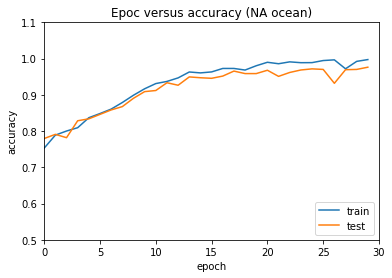

In [9]:
#Generating epoc s train versus test accuracy
noOfTrain = 5 # T = 5 (24 hours)
cnnData, yy, leads = load_dataCNN(data_pad, noOfTrain)

model = build_model(cnnData.shape)
yy = yy.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(cnnData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]

Xc_test = cnnData[test_index]
yc_test = yy[test_index]

history =  model.fit(Xc_train, yc_train, batch_size=32, validation_data=(Xc_test, yc_test) ,epochs=30,verbose=1, shuffle = True)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,30,0.5,1.1]) 
plt.title('Epoch versus accuracy (NA ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()